<a href="https://colab.research.google.com/github/dsaint31x/AOculus/blob/master/ch12_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np

np.random.seed(23)
tf.random.set_seed(23)

In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(type(housing.data), housing.data.shape)
print(type(housing.target),housing.target.shape)

<class 'numpy.ndarray'> (20640, 8)
<class 'numpy.ndarray'> (20640,)


In [13]:
from sklearn.model_selection import train_test_split

x_train_full, x_test, y_train, y_test = train_test_split(housing.data, housing.target.reshape(-1,1),
                                                         test_size=0.25,
                                                         random_state=23,
                                                         )

In [14]:
x_train_full.shape[0]/housing.data.shape[0]

0.75

In [16]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train, 
                                                      test_size = 0.25,
                                                      random_state=23,
                                                      )
print(x_train.shape[0]/x_train_full.shape[0])

0.75


In [17]:
from sklearn.preprocessing import StandardScaler

st = StandardScaler()
x_train_scaled = st.fit_transform(x_train)
x_valid_scaled = st.transform(x_valid)
x_test_scaled  = st.transform(x_test)

input_shape = x_train_scaled.shape[1:]
print(input_shape)

(8,)


In [20]:
from tensorflow.python.ops.init_ops_v2 import Initializer
reg_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Dense(30,
                          activation=tf.keras.activations.relu,
                          kernel_initializer=tf.keras.initializers.he_normal,
                          ),
    tf.keras.layers.Dense(1),
])
reg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                270       
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


# Custom Loss

The ***Huber*** loss is a combination of MSE and MAE. 

It is quadratic when the error is smaller than a threshold $\delta$ (typically 1) but linear when the error is larger than $\delta$. The linear part makes it less sensitive to outliers than the mean squared error, and the quadratic part allows it to converge faster and be more precise than the mean absolute error. 

In [21]:
def huber_fn (y_trues,y_preds):
  errors = y_trues - y_preds
  is_quadratic_loss = tf.abs(errors) < 1.
  quadratic_loss = 0.5 * tf.square(errors)
  linear_loss = tf.abs(errors) - .5
  return tf.where(is_quadratic_loss, quadratic_loss, linear_loss)


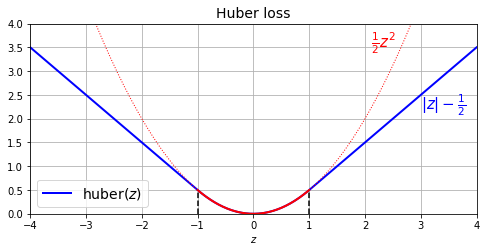

In [23]:
# extra code – shows what the Huber loss looks like

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
z_center = np.linspace(-1, 1, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z ** 2 / 2, "r:", linewidth=1)
plt.plot(z_center, z_center ** 2 / 2, "r", linewidth=2)
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "k--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "k--")
# plt.gca().axhline(y=0, color='k')
# plt.gca().axvline(x=0, color='k')
plt.text(2.1, 3.5, r"$\frac{1}{2}z^2$", color="r", fontsize=15)
plt.text(3.0, 2.2, r"$|z| - \frac{1}{2}$", color="b", fontsize=15)
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [34]:
reg_model.compile(
    loss = huber_fn,
    optimizer = "nadam",
    metrics = [tf.keras.metrics.mean_squared_error,]
)

In [36]:
reg_model.fit(x_train_scaled, y_train,
              epochs=2,
              validation_data=[x_valid_scaled,y_valid])

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 0.4291 - mean_squared_error: 1.1734 - val_loss: 0.2939 - val_mean_squared_error: 0.7578
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2419 - mean_squared_error: 0.5897 - val_loss: 0.2249 - val_mean_squared_error: 0.5586


In [38]:
reg_model.evaluate(x_test_scaled,y_test) # return [loss, mse]

162/162 [==============================] - 0s 2ms/step - loss: 0.2145 - mean_squared_error: 0.5442


[0.21450355648994446, 0.5441712141036987]

# Saving/Loading Models with Custom Objects


In [46]:
reg_model.save('reg_model.h5', save_format='h5')

In [47]:
!ls

reg_model.h5  sample_data


In [49]:
m2 = tf.keras.models.load_model('reg_model.h5') # error becuase of custom loss, huber_fn

ValueError: ignored

In [50]:
m2 = tf.keras.models.load_model(
    'reg_model.h5',
    custom_objects = {'huber_fn':huber_fn},
)

In [52]:
m2.fit(x_train_scaled, y_train,
       epochs=2,
       validation_data=[x_valid_scaled,y_valid],
       )

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.1971 - mean_squared_error: 0.4632 - val_loss: 0.1982 - val_mean_squared_error: 0.4752
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.1800 - mean_squared_error: 0.4179 - val_loss: 0.1857 - val_mean_squared_error: 0.4414


In [54]:
m2.evaluate(x_test_scaled, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.1732 - mean_squared_error: 0.4054


[0.1732175499200821, 0.40536999702453613]

In [55]:
def gen_huber_fn(threshold=0.5):
  def huber_fn(y_trues, y_preds):
    err = y_trues - y_preds
    is_quadratic_loss = tf.abs(err) < threshold
    quadratic_loss = tf.pow(err,2) * 0.5
    linear_loss = tf.abs(err) - 0.5
    return tf.where(is_quadratic_loss, quadratic_loss, linear_loss)

  return huber_fn


In [58]:
m2.compile(
    optimizer = "nadam",
    loss = gen_huber_fn(1.),
)
m2.fit(x_train_scaled, y_train,
       epochs=2,
       validation_data=[x_valid_scaled, y_valid],
       )

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.1668 - val_loss: 0.1771
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.1634 - val_loss: 0.1724


In [59]:
reg_model.save("reg_model", save_format='tf')

In [60]:
m3 = tf.keras.models.load_model('reg_model',
                                custom_objects={'huber_fn':gen_huber_fn(0.5,)})

In [61]:
m3.fit(
    x_train_scaled, y_train,
    validation_data=[x_valid_scaled, y_valid,],
    epochs=2,
)

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.1838 - mean_squared_error: 0.4629 - val_loss: 0.1847 - val_mean_squared_error: 0.4709
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.1656 - mean_squared_error: 0.4130 - val_loss: 0.1722 - val_mean_squared_error: 0.4377
